In [153]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

### Load MNIST

In [2]:
mnist = tfds.image.MNIST()

# Describe the dataset with DatasetInfo
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

mnist_dataset = mnist.as_dataset(batch_size=-1)

x_train = mnist_dataset['train']['image']
y_train = mnist_dataset['train']['label']
x_test  = mnist_dataset['test']['image']
y_test  = mnist_dataset['test']['label']

x_train = tf.cast(x_train, tf.float32)/255.0
x_test = tf.cast(x_test, tf.float32)/255.0

## Create and train the model

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model.fit(
                x = x_train,
                y = y_train,
                shuffle=True,
                epochs=20,
                batch_size=128,
                validation_data=(x_test, y_test),
              )

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3158 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.1453 - val_sparse_categorical_accuracy: 0.9576
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.1151 - val_sparse_categorical_accuracy: 0.9641
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.0832 - val_sparse_categorical_accuracy: 0.9743
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0919 - val_sparse_categorical_accuracy: 0.9711
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0785 - val_sparse_categorical_accuracy: 0.9752
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0396 - sparse_categorica

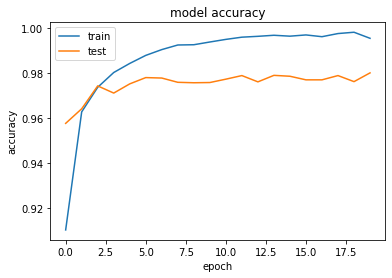

In [4]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
predictions_test = model.predict(x_test)

In [6]:
predictions_test.shape

(10000, 10)

In [7]:
predictions_train = model.predict(x_train)

## Check Model

Now that the initial model is trained, we need to train our check model.
We need to 

 1. come up with an initial transformation function for x
 2. figure out what shape the check model should be (preferable smaller than initial model)
 3. train so x' -> y'

#### Model 1: Let's try to simply sum up rows of pixels and learn the output from them.

In [8]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [9]:
x_train_check = np.zeros((60000,28,1), dtype=np.float32)
x_test_check = np.zeros((10000,28,1), dtype=np.float32)

In [10]:
# x_train_numpy = x_train.numpy()

In [11]:
for i in range(0,60000):
    x_train_check[i] = sum(x_train[i])

In [12]:
for i in range(0,10000):
    x_test_check[i] = sum(x_test[i])

In [13]:
x_train_check.shape

(60000, 28, 1)

In [14]:
sum(x_train[0]).shape

TensorShape([28, 1])

In [15]:
model_check = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,1)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(10)
])
model_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model_check.fit(
                x = x_train_check,
                y = y_train,
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_check, y_test),
                verbose=0
              )

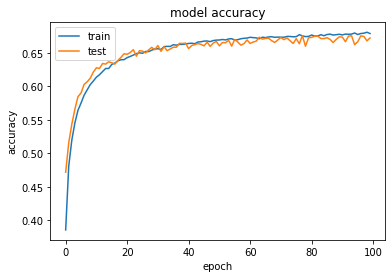

In [16]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

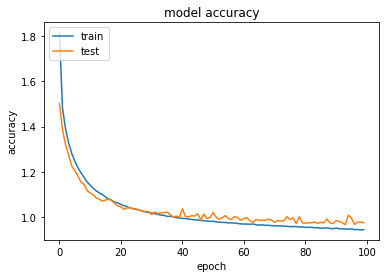

In [17]:
plt.plot(train_stats.history['loss'])
plt.plot(train_stats.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Result summary for model 1

This is basically just doing a worse, less accurate model.
It is only 60% accurate, meaning it is useless for detecting errors
We need to try so

#### Model 2:

For this model, let us sum across multiple inputs (temporally).

For example, lets say our batch size is 5. We sum up all the pixels across that batch
Similar to superimposing multiple images on top of eachother

We will also sum up the results (maybe the raw values, maybe 1 or zero)

Then we will train/test on that data. Worth a shot




In [18]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [19]:
concat_size = 5
train_len = int(60000/concat_size)
print(train_len)
test_len = int(10000/concat_size)
print(test_len)

12000
2000


In [20]:
x_train_check1 = np.zeros((train_len,28,28,1), dtype=np.float32)
x_test_check1 = np.zeros((test_len,28,28,1), dtype=np.float32)

In [21]:
predictions_train_check1 = np.zeros((train_len,10), dtype=np.float32)
predictions_test_check1 = np.zeros((test_len,10), dtype=np.float32)

In [22]:
j = 0
i = 0
while i < 60000:
    x_train_check1[j] = sum(x_train[i:i+5])/5
    #predictions_train_check1[j] = sum(tf.nn.softmax(predictions_train[i:i+5]))/5
    predictions_train_check1[j] = sum(tf.one_hot(y_train[i:i+5], 10))/5
    i+=5
    j+=1


In [23]:
j = 0
i = 0
while i < 10000:
    x_test_check1[j] = sum(x_test[i:i+5])/5
    #predictions_test_check1[j] = sum(tf.nn.softmax(predictions_test[i:i+5]))/5
    predictions_test_check1[j] = sum(tf.one_hot(y_test[i:i+5], 10))/5
    i+=5
    j+=1


In [24]:
# NOTE may need to normalize these by the concat size
# May also need to sum predictions_train/test in a different way
# and normalize

# TODO maybe try a different loss function. 
# This seems to be for single label
# or change the prediction so that there is a label for every
# different combo of numbers

In [25]:
model_check1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model_check1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

train_stats = model_check1.fit(
                x = x_train_check1,
                y = predictions_train_check1,
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_check1, predictions_test_check1),
                verbose=0
              )

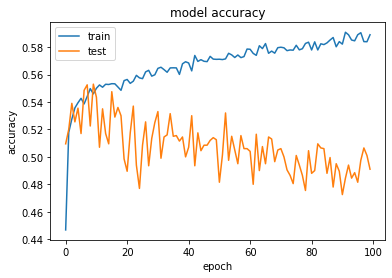

In [28]:
plt.plot(train_stats.history['categorical_accuracy'])
plt.plot(train_stats.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

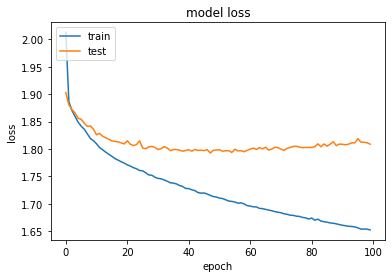

In [29]:
plt.plot(train_stats.history['loss'])
plt.plot(train_stats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
predictions_train[0]

array([-19.068153  ,   9.351563  , -13.903353  ,  -7.159692  ,
        18.381254  ,  -8.300275  , -14.584712  ,  -0.48819745,
        -5.1878414 ,  -2.4459643 ], dtype=float32)

In [31]:
tf.nn.softmax(predictions_train)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[5.4434731e-17, 1.1978519e-04, 9.5262357e-15, ..., 6.3833596e-09,
        5.8079087e-11, 9.0115954e-10],
       [1.0250121e-14, 9.9999988e-01, 8.3791630e-14, ..., 1.5603887e-07,
        2.0351468e-10, 1.0109887e-08],
       [1.0000000e+00, 6.4607296e-14, 2.1822502e-09, ..., 4.5350446e-19,
        9.5826288e-16, 2.4039399e-16],
       ...,
       [3.7811011e-11, 7.8091339e-15, 3.0810850e-16, ..., 2.3935242e-18,
        1.3615292e-16, 5.2047602e-16],
       [1.1163703e-18, 9.9999964e-01, 6.6319557e-13, ..., 1.7697760e-09,
        1.9361245e-07, 4.6566109e-11],
       [9.2807638e-14, 8.0510963e-14, 1.1568633e-18, ..., 2.8963112e-12,
        2.1523602e-08, 5.0601814e-12]], dtype=float32)>

In [ ]:
y_train

In [ ]:
tf.one_hot(y_train[0:5], 10)

In [ ]:
y_train[0:5]

### Model 3:

In this model we will train semi normally, but add extra outputs that will not be trained to try to use for error detection

In [3]:
# Define model layers.
input_layer = tf.keras.layers.Input(shape=(28,28,1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
first_dense = tf.keras.layers.Dense(units='128', activation='relu')(flatten_layer)

# Y1 output will be fed from the first dense
# y1_output = Dense(units='1', name='price_output')(first_dense)
categorical_output = tf.keras.layers.Dense(units='10', 
                                           kernel_initializer='ones',
                                           bias_initializer='zeros',
                                           name='category_output')(first_dense)

# second_dense = Dense(units='128',activation='relu')(first_dense)
# Y2 output will be fed from the second dense
check_output = tf.keras.layers.Dense(units='2',name='check_output')(categorical_output)

# Define the model with the input layer 
# and a list of output layers
model3 = tf.keras.Model(inputs=input_layer,outputs=[categorical_output, check_output])

In [4]:
# Specify the optimizer, and compile the model with loss functions for both outputs

# optimizer=tf.keras.optimizers.Adam(0.001),
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],

model3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss={'category_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics={'category_output':tf.keras.metrics.SparseCategoricalAccuracy()}
             )

In [5]:
# Train the model for 100 epochs
history = model3.fit(x = x_train,
                     y = {'category_output': y_train},
                     shuffle=True,
                     epochs=30, batch_size=128, 
                     validation_data=(x_test, y_test))

Epoch 1/30


469/469 [==============================] - 1s 3ms/step - loss: 0.4787 - category_output_loss: 0.4787 - category_output_sparse_categorical_accuracy: 0.8692 - val_loss: 0.2590 - val_category_output_loss: 0.2590 - val_category_output_sparse_categorical_accuracy: 0.9268
Epoch 2/30
469/469 [==============================] - 1s 2ms/step - loss: 0.2243 - category_output_loss: 0.2243 - category_output_sparse_categorical_accuracy: 0.9359 - val_loss: 0.1813 - val_category_output_loss: 0.1813 - val_category_output_sparse_categorical_accuracy: 0.9476
Epoch 3/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1612 - category_output_loss: 0.1612 - category_output_sparse_categorical_accuracy: 0.9536 - val_loss: 0.1385 - val_category_output_loss: 0.1385 - val_category_output_sparse_categorical_accuracy: 0.9586
Epoch 4/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1241 - category_output_loss: 0.1241 - category_output_sparse_categorical_accuracy: 0.9638 - val_loss:

In [6]:
model3_train_predictions = model3.predict(x_train)
model3_test_predictions = model3.predict(x_test)

In [71]:
model3.evaluate(x_train, y_train)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0082 - category_output_loss: 0.0082 - category_output_sparse_categorical_accuracy: 0.9978


[0.008246034383773804, 0.008246034383773804, 0.997783362865448]

In [72]:
model3.evaluate(x_test, y_test)

313/313 [==============================] - 0s 925us/step - loss: 0.0989 - category_output_loss: 0.0989 - category_output_sparse_categorical_accuracy: 0.9775


[0.0988721027970314, 0.0988721027970314, 0.9775000214576721]

In [7]:
print(model3_train_predictions[0].shape)
print(model3_train_predictions[1].shape)

(60000, 10)
(60000, 2)


In [8]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [17]:
model3_check = tf.keras.models.Sequential([
                   tf.keras.layers.Flatten(input_shape=(28,28)),
                   tf.keras.layers.Dense(64,activation='relu'),
                   tf.keras.layers.Dense(2)
               ])
model3_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()],
)

train_stats = model3_check.fit(
                x = x_train,
                y = model3_train_predictions[1],
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, model3_test_predictions[1]),
                verbose=0
              )

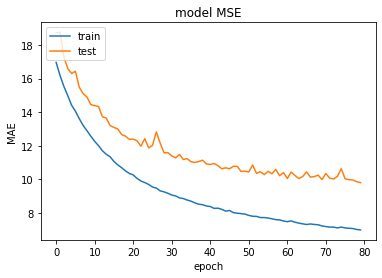

In [22]:
plt.plot(train_stats.history['mean_squared_error'][20:])
plt.plot(train_stats.history['val_mean_squared_error'][20:])
plt.title('model MSE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

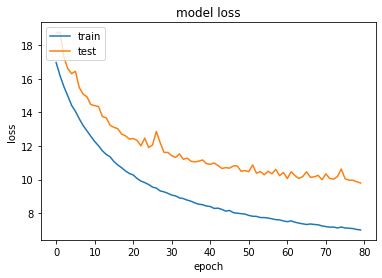

In [24]:
plt.plot(train_stats.history['loss'][20:])
plt.plot(train_stats.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
model3_check.evaluate(x_train, model3_train_predictions[1])

1875/1875 [==============================] - 2s 1ms/step - loss: 6.6542 - mean_squared_error: 6.6542 - mean_absolute_error: 1.9775 - accuracy: 0.0000e+00


[6.654230117797852, 6.654230117797852, 1.9774984121322632, 0.0]

In [25]:
model3_check.predict(x_train[0:1])

array([[-64.00462,  79.1978 ]], dtype=float32)

In [26]:
model3_train_predictions[1][0]

array([-64.22179,  82.23684], dtype=float32)

In [27]:
model3_check.predict(x_test[400:401])

array([[-145.68459 ,  126.530876]], dtype=float32)

In [28]:
model3_test_predictions[1][400]

array([-145.31837,  124.87227], dtype=float32)

In [29]:
tf.keras.losses.MSE(model3_train_predictions[1][0], model3_check.predict(x_train[0:1]))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.641461], dtype=float32)>

In [30]:
model3_train_check_predictions = model3_check.predict(x_train)

In [31]:
model3_train_mses = tf.keras.losses.MSE(model3_train_predictions[1], model3_train_check_predictions)

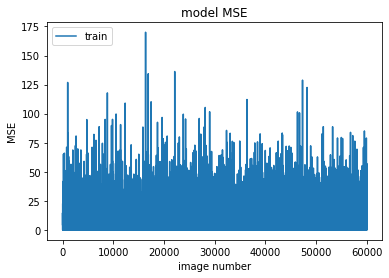

In [70]:
plt.plot(model3_train_mses)
# plt.plot(train_stats.history['val_mean_squared_error'][20:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('image number')
plt.legend(['train'], loc='upper left')
plt.show()

In [63]:
model3_train_mses[16369]

<tf.Tensor: shape=(), dtype=float32, numpy=170.00104>

In [64]:
model3_train_predictions[1][16369]

array([-133.92714,  146.42326], dtype=float32)

In [65]:
model3_train_check_predictions[16369]

array([-146.29346,  160.10085], dtype=float32)

In [66]:
model3_train_predictions[0][16369]

array([229.54109, 253.55153, 277.1634 , 268.40735, 217.60033, 244.73288,
       218.73737, 253.83977, 258.8689 , 218.62125], dtype=float32)

In [67]:
tf.nn.softmax(model3_train_predictions[0][16369])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2.0788822e-21, 5.5645513e-11, 9.9984252e-01, 1.5748192e-04,
       1.3552561e-26, 8.2326453e-15, 4.2250435e-26, 7.4235312e-11,
       1.1343147e-08, 3.7618472e-26], dtype=float32)>

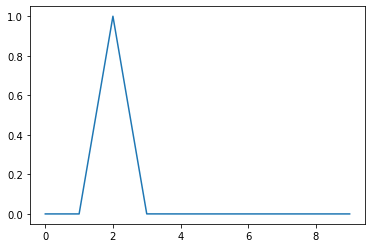

In [68]:
plt.plot(tf.nn.softmax(model3_train_predictions[0][16369]))
# plt.plot(train_stats.history['val_mean_squared_error'][20:])
plt.show()

In [69]:
y_train[16369]

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [83]:
p = model3.predict(x_test[0:1])
s = tf.nn.softmax(p[0])
int(tf.math.argmax(s, axis=-1))

2

In [85]:
int(y_test[0])

2

In [93]:
model3_test_predictions = model3.predict(x_test)

In [97]:
model3_test_predictions[0][0]

array([184.3096 , 196.1389 , 222.29498, 195.25058, 189.12245, 185.07591,
       186.62585, 185.32466, 198.02336, 174.91527], dtype=float32)

In [99]:
incorrect_array = []

for i in range(0, 10000):
    p = model3_test_predictions[0][i]
    s = tf.nn.softmax(p)
    tmp_int = int(tf.math.argmax(s, axis=-1))
    if int(y_test[i]) != tmp_int:
        incorrect_array.append(i)

print(incorrect_array)

[13, 30, 33, 152, 205, 216, 221, 328, 372, 392, 435, 454, 491, 505, 510, 588, 659, 713, 747, 871, 900, 901, 941, 1067, 1113, 1132, 1138, 1307, 1320, 1321, 1441, 1521, 1541, 1542, 1599, 1632, 1686, 1764, 1768, 1831, 1849, 1901, 1948, 2026, 2030, 2221, 2238, 2323, 2343, 2385, 2395, 2445, 2455, 2490, 2491, 2527, 2604, 2679, 2695, 2734, 2757, 2765, 2846, 2922, 2984, 2993, 2999, 3018, 3023, 3025, 3063, 3107, 3184, 3289, 3302, 3315, 3321, 3369, 3490, 3524, 3647, 3652, 3702, 3721, 3729, 3753, 3766, 3767, 3837, 3926, 3933, 3984, 3990, 4079, 4134, 4196, 4200, 4205, 4226, 4271, 4329, 4334, 4479, 4545, 4592, 4676, 4751, 4808, 4809, 4894, 5071, 5074, 5141, 5226, 5247, 5269, 5273, 5282, 5329, 5444, 5556, 5577, 5608, 5684, 5743, 5746, 5796, 5799, 5846, 5849, 5868, 5879, 5915, 5929, 5938, 6074, 6120, 6249, 6315, 6328, 6333, 6339, 6348, 6373, 6489, 6511, 6516, 6520, 6603, 6663, 6692, 6723, 6790, 6821, 6929, 6963, 7017, 7037, 7049, 7076, 7148, 7152, 7195, 7201, 7215, 7247, 7300, 7383, 7446, 7453, 7577,

In [102]:
model3_check.evaluate(x_test, model3_test_predictions[1])

313/313 [==============================] - 0s 885us/step - loss: 9.7954 - mean_squared_error: 9.7980 - mean_absolute_error: 2.3603 - accuracy: 0.0000e+00


[9.795434951782227, 9.798005104064941, 2.3602688312530518, 0.0]

In [128]:
model3_check.predict(x_test[13:14])

array([[-85.21603, 109.64496]], dtype=float32)

In [129]:
model3_test_predictions[1][13]

array([-84.05022, 105.67674], dtype=float32)

In [106]:
model3_check.predict(x_test[400:401])

array([[-145.68459 ,  126.530876]], dtype=float32)

In [107]:
model3_test_predictions[1][400]

array([-145.31837,  124.87227], dtype=float32)

In [108]:
tf.keras.losses.MSE(model3_test_predictions[1][0], model3_check.predict(x_test[0:1]))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.4372942], dtype=float32)>

In [109]:
model3_test_check_predictions = model3_check.predict(x_test)

In [110]:
model3_test_mses = tf.keras.losses.MSE(model3_test_predictions[1], model3_test_check_predictions)

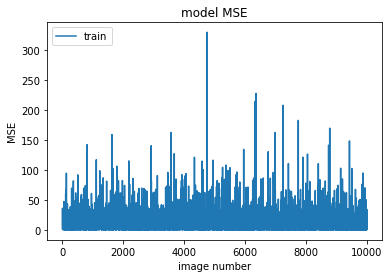

In [113]:
plt.plot(model3_test_mses)
# plt.plot(train_stats.history['val_mean_squared_error'][20:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('image number')
plt.legend(['train'], loc='upper left')
plt.show()

In [145]:
np.mean(model3_test_mses)

9.795434

In [146]:
np.median(model3_test_mses)

4.8640065

In [152]:
scipy.stats.describe(model3_test_mses)

DescribeResult(nobs=10000, minmax=(0.0015028712, 329.40527), mean=9.795434, variance=222.05933, skewness=5.0224385261535645, kurtosis=50.120233302070524)

In [114]:
tf.math.argmax(model3_test_mses, axis=-1)

<tf.Tensor: shape=(), dtype=int64, numpy=4751>

In [116]:
model3_test_mses[4751]

<tf.Tensor: shape=(), dtype=float32, numpy=329.40527>

In [137]:
highest_mses = tf.math.greater(model3_test_mses, 25)
highest_mses_indexes = []
for i in range(0,int(highest_mses.shape[-1])):
    if highest_mses[i]:
        highest_mses_indexes.append(i)

In [138]:
set(highest_mses_indexes).intersection(set(incorrect_array))

{221,
 392,
 435,
 454,
 491,
 505,
 747,
 871,
 901,
 1113,
 1320,
 1764,
 1849,
 2026,
 2238,
 2455,
 2490,
 2922,
 2984,
 3302,
 3321,
 3837,
 3984,
 4079,
 4329,
 4592,
 4676,
 4751,
 4809,
 5074,
 5226,
 5796,
 5915,
 5929,
 6348,
 6663,
 6790,
 6929,
 7049,
 7247,
 7698,
 8338,
 8550,
 8569,
 8667,
 8876,
 9495,
 9608,
 9627,
 9944}

### Model 4:

Similar to model 3, but use a reduced size derivative of the original inputs for the check function

In [154]:
x_train_check_sum = np.zeros((60000,28,1), dtype=np.float32)
x_test_check_sum = np.zeros((10000,28,1), dtype=np.float32)

In [155]:
# x_train_numpy = x_train.numpy()

In [156]:
for i in range(0,60000):
    x_train_check_sum[i] = sum(x_train[i])

In [157]:
for i in range(0,10000):
    x_test_check_sum[i] = sum(x_test[i])

In [159]:
x_train_check_sum.shape

(60000, 28, 1)

In [160]:
sum(x_train[0]).shape

TensorShape([28, 1])

In [161]:
model4_check = tf.keras.models.Sequential([
                   tf.keras.layers.Flatten(input_shape=(28,1)),
                   tf.keras.layers.Dense(64,activation='relu'),
                   tf.keras.layers.Dense(2)
               ])
model4_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()],
)

train_stats = model4_check.fit(
                x = x_train_check_sum,
                y = model3_train_predictions[1],
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_check_sum, model3_test_predictions[1]),
                verbose=0
              )

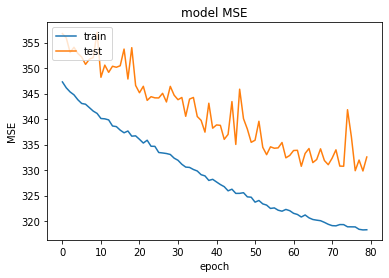

In [163]:
plt.plot(train_stats.history['mean_squared_error'][20:])
plt.plot(train_stats.history['val_mean_squared_error'][20:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

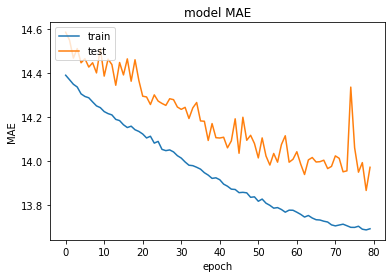

In [168]:
plt.plot(train_stats.history['mean_absolute_error'][20:])
plt.plot(train_stats.history['val_mean_absolute_error'][20:])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

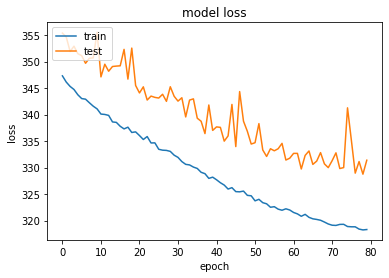

In [164]:
plt.plot(train_stats.history['loss'][20:])
plt.plot(train_stats.history['val_loss'][20:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [167]:
model4_check.evaluate(x_train_check_sum, model3_train_predictions[1])

1875/1875 [==============================] - 2s 910us/step - loss: 317.5333 - mean_squared_error: 317.5333 - mean_absolute_error: 13.6741 - accuracy: 0.0000e+00


[317.5333251953125, 317.5333251953125, 13.674067497253418, 0.0]

#### Review of model 4

A lot worse them model 3

### Model 5

In this model, we will use a similar check model to model 3, but the main model will be more complex

In [267]:
# Define model layers.
input_layer = tf.keras.layers.Input(shape=(28,28,1))
conv2d_layer_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform')(input_layer)
maxpool_layer_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_layer_1)
flatten_layer = tf.keras.layers.Flatten()(maxpool_layer_1)
dense_layer_1 = tf.keras.layers.Dense(units='128', activation='relu', kernel_initializer='he_uniform')(flatten_layer)

# Y1 output will be fed from the first dense
# y1_output = Dense(units='1', name='price_output')(first_dense)
categorical_output_1 = tf.keras.layers.Dense(units='10', 
                                           name='category_output',
                                           activation='softmax')(dense_layer_1)

# second_dense = Dense(units='128',activation='relu')(first_dense)
# Y2 output will be fed from the second dense
check_output_1 = tf.keras.layers.Dense(units='2',
#                                      kernel_initializer='ones',
#                                      bias_initializer='zeros',
                                     name='check_output')(categorical_output_1)

# Define the model with the input layer 
# and a list of output layers
model5 = tf.keras.Model(inputs=input_layer,outputs=[categorical_output_1, check_output_1])

In [268]:
# Specify the optimizer, and compile the model with loss functions for both outputs

# optimizer=tf.keras.optimizers.Adam(0.001),
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],

model5.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss={'category_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics={'category_output':tf.keras.metrics.SparseCategoricalAccuracy()}
             )

In [269]:
# Train the model for 100 epochs
history = model5.fit(x = x_train,
                     y = {'category_output': y_train},
                     shuffle=True,
                     epochs=10, batch_size=128, 
                     validation_data=(x_test, y_test))

Epoch 1/10


469/469 [==============================] - 12s 25ms/step - loss: 1.5425 - category_output_loss: 1.5425 - category_output_sparse_categorical_accuracy: 0.9243 - val_loss: 1.4990 - val_category_output_loss: 1.4990 - val_category_output_sparse_categorical_accuracy: 0.9645
Epoch 2/10
469/469 [==============================] - 12s 25ms/step - loss: 1.4906 - category_output_loss: 1.4906 - category_output_sparse_categorical_accuracy: 0.9731 - val_loss: 1.4874 - val_category_output_loss: 1.4874 - val_category_output_sparse_categorical_accuracy: 0.9758
Epoch 3/10
469/469 [==============================] - 11s 24ms/step - loss: 1.4811 - category_output_loss: 1.4811 - category_output_sparse_categorical_accuracy: 0.9818 - val_loss: 1.4785 - val_category_output_loss: 1.4785 - val_category_output_sparse_categorical_accuracy: 0.9850
Epoch 4/10
469/469 [==============================] - 12s 25ms/step - loss: 1.4762 - category_output_loss: 1.4762 - category_output_sparse_categorical_accuracy: 0.9867 - v

In [270]:
model5_train_predictions = model5.predict(x_train)
model5_test_predictions = model5.predict(x_test)

In [271]:
model5_test_predictions[0][0]

array([9.6485198e-21, 8.5245886e-17, 1.0000000e+00, 1.6827537e-15,
       1.0500188e-17, 1.3637083e-22, 1.3638192e-27, 1.9219506e-20,
       1.4275667e-13, 4.6405742e-18], dtype=float32)

In [272]:
model5.evaluate(x_train, y_train)

1875/1875 [==============================] - 6s 3ms/step - loss: 1.4660 - category_output_loss: 1.4660 - category_output_sparse_categorical_accuracy: 0.9958


[1.4659879207611084, 1.4659879207611084, 0.9958333373069763]

In [273]:
model5.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4758 - category_output_loss: 1.4758 - category_output_sparse_categorical_accuracy: 0.9859


[1.4757825136184692, 1.4757825136184692, 0.9858999848365784]

In [274]:
model5_check = tf.keras.models.Sequential([
                   tf.keras.layers.Flatten(input_shape=(28,28)),
                   tf.keras.layers.Dense(64,activation='relu'),
                   tf.keras.layers.Dense(2)
               ])
model5_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()],
)

train_stats = model5_check.fit(
                x = x_train,
                y = model5_train_predictions[1],
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, model5_test_predictions[1]),
                verbose=0
              )

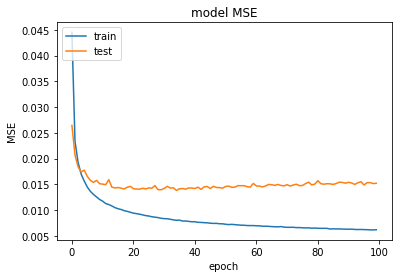

In [275]:
plt.plot(train_stats.history['mean_squared_error'][:])
plt.plot(train_stats.history['val_mean_squared_error'][:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

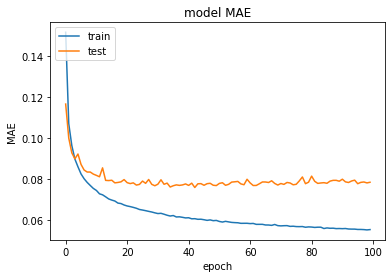

In [276]:
plt.plot(train_stats.history['mean_absolute_error'][:])
plt.plot(train_stats.history['val_mean_absolute_error'][:])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

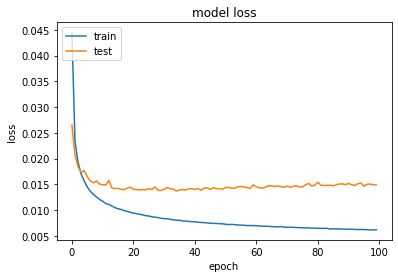

In [277]:
plt.plot(train_stats.history['loss'][:])
plt.plot(train_stats.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [278]:
model5_check.evaluate(x_train, model5_train_predictions[1])

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0538 - accuracy: 0.0000e+00


[0.00578839099034667, 0.00578839099034667, 0.053779471665620804, 0.0]

In [279]:
model5_check_train_predictions = model5_check.predict(x_train)

In [290]:
model5_check_train_predictions[10]

array([0.6609125, 0.3420861], dtype=float32)

In [291]:
model5_train_predictions[1][10]

array([0.6353578 , 0.35095686], dtype=float32)

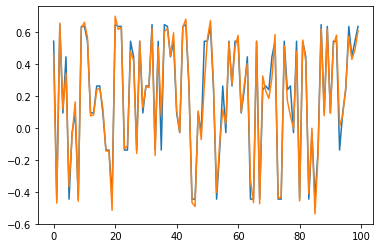

In [286]:
plt.plot(model5_train_predictions[1][0:100,0])
plt.plot(model5_check_train_predictions[0:100,0])
# plt.title('model MSE')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [288]:
model5_check_test_predictions = model5_check.predict(x_test)

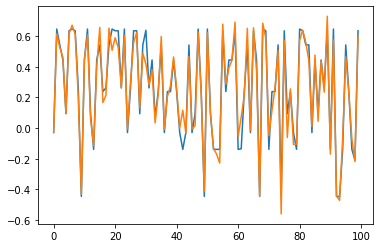

In [289]:
plt.plot(model5_test_predictions[1][0:100,0])
plt.plot(model5_check_test_predictions[0:100,0])
# plt.title('model MSE')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()